<a href="https://colab.research.google.com/github/space-debris/ANN/blob/main/lstm_with_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import optuna
import matplotlib.pyplot as plt

In [ ]:
# Load and prepare the dataset
iris = load_iris()
X = iris.data
y = iris.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Define the model function for Optuna
def create_model(units, learning_rate, batch_size):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_int('batch_size', 4, 16)

    model = create_model(units, learning_rate, batch_size)
    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0, validation_split=0.2)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

In [ ]:
# Set up the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)

print(f'Best trial: {study.best_trial.number}')
print(f'Best value: {study.best_value}')
print(f'Best parameters: {study.best_params}')

In [ ]:
# Extract best parameters
best_params = study.best_params
best_units = best_params['units']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']

In [ ]:
# Rebuild the model with best parameters
best_model = create_model(best_units, best_learning_rate, best_batch_size)

In [ ]:
# Train the model with best parameters
history = best_model.fit(X_train, y_train, epochs=50, batch_size=best_batch_size, validation_split=0.2, verbose=1)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy with best parameters: {accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[I 2024-07-23 17:27:22,490] A new study created in memory with name: no-name-adb03af7-89fb-4cc7-9651-ba41c65397ea
<ipython-input-2-4497784f8d4b>:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-07-23 17:27:33,766] Trial 0 finished with value: 0.9666666388511658 and parameters: {'units': 59, 'learning_rate': 0.0034464977845521656, 'batch_size': 7}. Best is trial 0 with value: 0.9666666388511658.
[I 2024-07-23 17:27:48,355] Trial 1 finished with value: 0.8666666746139526 and parameters: 

Best trial: 4
Best value: 1.0
Best parameters: {'units': 77, 'learning_rate': 0.0012395562580796576, 'batch_size': 13}
Epoch 1/50
8/8 [==============================] - 2s 86ms/step - loss: 1.0897 - accuracy: 0.4688 - val_loss: 1.0676 - val_accuracy: 0.4167
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 1.0245 - accuracy: 0.6771 - val_loss: 1.0110 - val_accuracy: 0.5833
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.9619 - accuracy: 0.8958 - val_loss: 0.9561 - val_accuracy: 0.8750
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.9007 - accuracy: 0.8750 - val_loss: 0.9042 - val_accuracy: 0.9167
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.8412 - accuracy: 0.8646 - val_loss: 0.8527 - val_accuracy: 0.8750
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 0.7818 - accuracy: 0.8542 - val_loss: 0.8026 - val_accuracy: 0.8750
Epoch 7/50
8/8 [==============================]

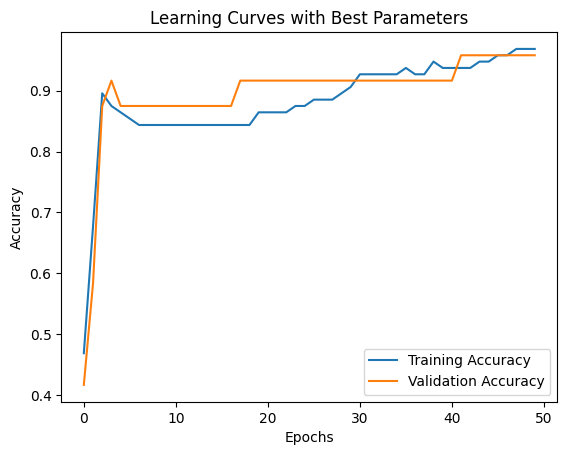

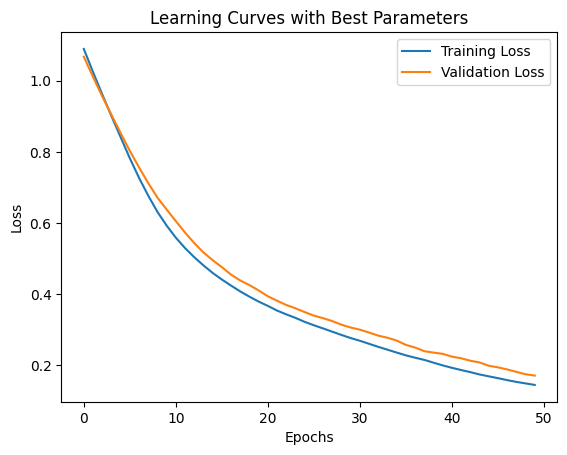

In [2]:
# Plot learning curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curves with Best Parameters')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves with Best Parameters')
plt.show()
